In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import transformers
import torch
print(torch.cuda.is_available())

True


In [21]:
df = pd.read_csv("/content/drive/MyDrive/HCL Training Project/guardian_headlines.csv")

In [22]:
df.drop("tag", axis=1, inplace=True)

In [23]:
df

,headline,Topic
0,A Ukrainian soldier rehabilitates after Russia...,World
1,Epstein's buddies were arrested in the UK. In ...,Politics
2,Patel and Trump overshadowed US hockey's Olymp...,Sports
3,America says goodbye to the mass-market paperback,Entertainment
4,Why I’m not watching Trump's State of the Union,Politics
...,...,...
4138,Snow: UK is closed until further notice,Politics
4139,Ali Hilli: 'My friend was beaten to death in t...,Politics
4140,World Cup: The money is flowing,Politics
4141,"'Journalism is about exceptions to the rule, w...",Politics


In [24]:
# Encoding the labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['Topic'])

num_labels = len(le.classes_)
print("Number of unique labels:", num_labels)

Number of unique labels: 6


In [25]:
# Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=18, stratify=df['label'])

In [26]:
# Converting to Hugging Face Datasets
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df[['headline', 'label']])
test_dataset = Dataset.from_pandas(test_df[['headline', 'label']])

In [27]:
# Loading the pre-trained model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [28]:
def tokenize(x):
    return tokenizer(
        x["headline"],
        truncation=True,
        padding="max_length",
        max_length=64
    )

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.remove_columns(['headline'])
test_dataset = test_dataset.remove_columns(['headline'])
train_dataset.set_format('torch')
test_dataset.set_format('torch')

Map:   0%|          | 0/3314 [00:00<?, ? examples/s]

Map:   0%|          | 0/829 [00:00<?, ? examples/s]

In [29]:
# Setting up training arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50
)

In [30]:
# Defining the compute_metrics function
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {
        "f1": f1,
        "accuracy": acc
    }

In [31]:
# Setting up the Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [32]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.667309,0.638638,0.615419,0.781665
2,0.358962,0.589403,0.670438,0.799759
3,0.214937,0.627628,0.664362,0.808203


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=624, training_loss=0.47283514340718585, metrics={'train_runtime': 83.8756, 'train_samples_per_second': 118.533, 'train_steps_per_second': 7.44, 'total_flos': 164635603011072.0, 'train_loss': 0.47283514340718585, 'epoch': 3.0})

In [33]:
trainer.evaluate()

{'eval_loss': 0.627627968788147,
 'eval_f1': 0.6643622622034653,
 'eval_accuracy': 0.8082026537997588,
 'eval_runtime': 1.5629,
 'eval_samples_per_second': 530.436,
 'eval_steps_per_second': 33.272,
 'epoch': 3.0}


Label ID → Class Name Mapping:
0 : Business
1 : Entertainment
2 : Lifestyle
3 : Politics
4 : Sports
5 : World


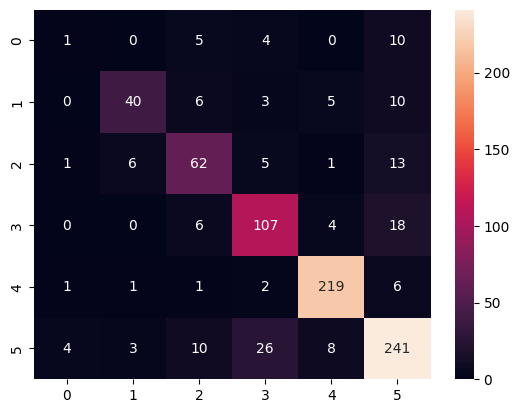

In [34]:
# Plotting Confusion Matrix

predictions = trainer.predict(test_dataset)

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

print("\nLabel ID → Class Name Mapping:")
for idx, class_name in enumerate(le.classes_):
    print(f"{idx} : {class_name}")

In [35]:
# Save the model and tokenizer

trainer.save_model("/content/drive/MyDrive/HCL Training Project/final_model")
tokenizer.save_pretrained("/content/drive/MyDrive/HCL Training Project/final_model")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('/content/drive/MyDrive/HCL Training Project/final_model/tokenizer_config.json',
 '/content/drive/MyDrive/HCL Training Project/final_model/tokenizer.json')